# Analysing the experimental data of  [Brydges et al, Science 2019](https://doi.org/10.1126/science.aau4963)

In this example, we illustrate the functionalities of the RandomMeas.jl package using actual experimental data obtained in  [Brydges et al., 2019](https://doi.org/10.1126/science.aau4963). It aims to estimate the purity and (higher-order) Renyi entropies of quantum states generated in an ion-trap quantum simulator.

## Experiment Description

The original experiment [Brydges et al., 2019] focused on measuring the purity (the second Renyi enropy) in an ion-trap quantum simulator. The main goals were:

- **Purity Measurement:**  
  To verify that the quantum device produces a nearly unitary dynamics, we measure the purity $Tr[\rho^2]$ of the (full-system) quantum state.

- **Entanglement Quantification:**  
  Subsystem purities are used to compute the second Rényi entropy, defined as  
  $$
  S_2(\rho_A) = -\log_2(p_2)
  $$
  where $ p_2 = Tr[\rho_A^2] $ is the purity of a subsystem. This metric provides insights into the entanglement structure of many-body quantum systems.

- **Experimental Setup:**  
  - The system consists of a chain of trapped ions (here $ N = 10 $ ), with each ion encoding a qubit.
  - Initial state: The qubits are initialized in a Néel state,
    $\ket{\psi} = \ket{01}^{\otimes (N/2)}$.
  - Quench dynamics: The system is evolved under an XY Hamiltonian,  
    $$
    H_{XY} = \sum_{i<j} J_{ij} \left( \sigma_i^+ \sigma_j^- + \text{h.c.} \right)
    $$
    with couplings $ J_{ij} \sim \frac{J}{|i - j|^\alpha} $ (with $ 0 < \alpha < 3 $) up to various times t.
  - Randomized measurements are performed by applying local single-qubit rotations sampled from the circular unitary ensemble before measurement. These rotations, combined with standard $Z$-basis measurements, yield data that is used to estimate purity and entanglement.

The experiment acquired data for multiple measurement settings ( $ N_U = 500 $ settings, each with $ N_M = 150 $ repetitions per settings).

## Notebook Overview

This notebook demonstrates several key functionalities of the RandomMeas.jl package:

- **Loading Experimental Data:**  
  The notebook shows how to load measurement data from NPZ files. The data consists of measurement results (a 3D array with dimensions $(NU, NM, N)$) and  includes local unitary measurement settings.

- **Direct Purity Estimation:**  
  Using the estimator presented in [Brydges et al., 2019], the notebook estimates the purity of the quantum state for various subsystem sizes (up to 10 sites).

- **Batch Classical Shadows:**  
  The notebook also demonstrates how to construct (batch) dense shadows and estimates higher order trace moments using U-statistics estimators. This approach allows us to extract higher-order Rényi entropies, albeit for smaller subsystems (up to $N_A = 6$).

- **Comparison to numerical simulations:**  
  Finally, the notebook includes an example of loading numerically simulated (theory) states generated using a decoherence model. These states are converted to MPO representations, and their Rényi entropies are computed to compare with the experimental data.

## Reference

Brydges, T., Elben, A., Jurcevic, P., Vermersch, B., Maier, C., Lanyon, B. P., Zoller, P., Blatt, R., & Roos, C. F. (2019). *Probing Rényi entanglement entropy via randomized measurements*. **Science, 364**(6437), 260–263.  [DOI: 10.1126/science.aau4963](https://doi.org/10.1126/science.aau4963)

In [ ]:
using RandomMeas

In [4]:
## parameters 
N = 10 # System size
times = [0,1,2,3,4,5] # quench times in ms
ntimes = length(times)  # number of time points

6

## Loading Experimental Data

We now load the experimental randomized measurement data obtained in [Brydges et al., 2019](https://doi.org/10.1126/science.aau4963). In this experiment, the goal was to probe the purity and entanglement of a quantum state generated in an ion-trap quantum simulator.

For each quench time $ t $ (0, 1, 2, 3, 4, 5 ms), we generate one measurement group. Each measurement group contains $ N_U = 500 $ measurement data objects, where each object consists of:
  
- **Experimental Data:**  
  The measurement outcomes obtained from $ N_M = 150 $ projective measurements for a given measurement setting.
  
- **Measurement Setting:**  
  The corresponding local random unitaries that specify the measurement setting for that data.

In [5]:
data = Vector{MeasurementGroup}(undef, ntimes)

for s in 1:ntimes   
    data[s] = import_MeasurementGroup("BrydgesScience2019data/measurement_data_10_T_" * string(times[s]) * ".npz")
end 

## Estimating Purity

We use the direct purity estimation formula from [Brydges et al., Science 2019](https://doi.org/10.1126/science.aau4963), which computes purity directly from the randomized measurement outcomes.

In [6]:
p_direct = zeros(Float64,ntimes,N)
@showprogress for s in 1:ntimes
    for NA in 1:N
        p_direct[s,NA] = get_purity(data[s],collect(1:NA))
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:27


We now estimation the purity via classical shadows. To speed up the computation of the U-statistics estimator, we use batch shadows (see also below) and restrict to a subsystem size of 8.

In [7]:
p_shadow = zeros(Float64,ntimes,N)

@showprogress for s in 1:ntimes
    for NA in 1:6
        reduced_data = reduce_to_subsystem(data[s],collect(1:NA)) # reduce the data to the subsystem [1,2,...,NA]
        dense_shadows = get_dense_shadows(reduced_data, number_of_ru_batches = 10) # get the batch dense shadows for that subsystem
        p_shadow[s,NA] = get_trace_moment(dense_shadows,2) # get the purity from the shadows
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:35


## Estimating Higher-Order Rényi Entropies via Batch Shadows

We estimate higher order Rényi entropies (up to order *5*) using batch shadows (cf. [Rath et al., PRXQ 2023](https://doi.org/10.1103/PRXQuantum.5.030338)) which allow in this case for faster post-processing than the original (standard) classical shadow [Huang et al., Nat. Phys. 2020](https://www.nature.com/articles/s41567-020-0932-7). In our analysis, for each subsystem of interest, we first reduce the measurement data to that subsystem. Next, we construct dense shadows from the reduced data by batching the randomized measurements. Finally, we estimate the trace moments of these shadows, from which the higher-order Rényi entropies can be computed. This procedure allows us to efficiently extract entanglement properties even for smaller subsystems.

In [8]:
# Parameters specifying the Renyi entropies of interest
k_max = 4 # maximal Renyi index (n-th Renyi entropy)
NA_max = 5; #maximal subsystem size. We always consider subsystems of the form [1,2,...,NA].

In [ ]:
S_bshadow = zeros(Float64,ntimes,NA_max,k_max-1)
S_bshadow_sem = zeros(Float64,ntimes,NA_max,k_max-1)

@showprogress for s in 1:ntimes
    for NA in 1:NA_max
        reduced_data = reduce_to_subsystem(data[s],collect(1:NA)) # reduce the data to the subsystem [1,2,...,NA]
        dense_shadows = get_dense_shadows(reduced_data; number_of_ru_batches = 2*k_max) # get the dense batch shadows for that subsystem
        for k in 2: k_max
            e,bias, sem = get_trace_moment(dense_shadows,k, compute_renyi = true, compute_sem=true) # get the tracemoment from the batch shadows
            S_bshadow[s,NA,k-1] = e
            S_bshadow_sem[s,NA,k-1] = sem
        end
        @show S_bshadow[s,NA,:]
        @show S_bshadow_sem[s,NA,:]
    end
end

S_bshadow[s, NA, :] = [0.04434554873063518, 0.03352009206293739, 0.029912442217959065]
S_bshadow_sem[s, NA, :] = [0.03170178842185317, 0.02416816511067382, 0.02147652539631801]
S_bshadow[s, NA, :] = [0.0951375554662067, 0.0704549579361439, 0.06307518162381563]
S_bshadow_sem[s, NA, :] = [0.06454766933655759, 0.04946011225654663, 0.04390368088124052]
S_bshadow[s, NA, :] = [0.18199792403621756, 0.13636656108016543, 0.12172263789045493]
S_bshadow_sem[s, NA, :] = [0.07182716214057022, 0.055619142515782816, 0.049486527270578305]
S_bshadow[s, NA, :] = [0.318264698307958, 0.24028617137220737, 0.21426115414472635]
S_bshadow_sem[s, NA, :] = [0.08528127422681, 0.06655061598426325, 0.05945114469687462]
S_bshadow[s, NA, :] = [0.3860592836546686, 0.2940362288472742, 0.2633629514105565]
S_bshadow_sem[s, NA, :] = [0.13950507090652933, 0.10488649402117813, 0.0933194067792757]
S_bshadow[s, NA, :] = [0.4328181802827996, 0.35511830836781083, 0.3190430928874106]
S_bshadow_sem[s, NA, :] = [0.032060534842330

Progress:  33%|█████████████▋                           |  ETA: 0:00:03


S_bshadow_sem[s, NA, :] = [0.08968419763388419, 0.0631865808683514, 0.05694821306251947]
S_bshadow[s, NA, :] = [0.9601299527422393, 0.9417752562584673, 0.9249509975496024]
S_bshadow_sem[s, NA, :] = [0.00623441754669758, 0.008852064227759839, 0.011030117988051986]
S_bshadow[s, NA, :] = [1.179359219471133, 1.0988945587175905, 1.0528468741439925]
S_bshadow_sem[s, NA, :] = [0.017148190194273015, 0.016517653876993513, 0.01765414876844012]
S_bshadow[s, NA, :] = [1.3786303674572313, 1.2653926121705315, 1.2139576143567323]
S_bshadow_sem[s, NA, :] = [0.056679663428209466, 0.049923569241515774, 0.04672283153192115]
S_bshadow[s, NA, :] = [1.4184590166952045, 1.2820811946678485, 1.2233975197299045]
S_bshadow_sem[s, NA, :] = [0.04579746881367626, 0.028263560199946976, 0.025083069619430794]
S_bshadow[s, NA, :] = [1.5062528590670745, 1.3492679276518855, 1.2878273602283996]

Progress:  50%|████████████████████▌                    |  ETA: 0:00:02


S_bshadow_sem[s, NA, :] = [0.06269464685197615, 0.04037418463942191, 0.035978762065108624]
S_bshadow[s, NA, :] = [0.9906316260604111, 0.9860377157798391, 0.9815411941580892]
S_bshadow_sem[s, NA, :] = [0.0015675006762765368, 0.0023217087458999677, 0.0030444955117300246]
S_bshadow[s, NA, :] = [1.5807381665956655, 1.4695316025798306, 1.3989086507660753]
S_bshadow_sem[s, NA, :] = [0.022142671929620487, 0.02461709247871845, 0.025721624690228453]
S_bshadow[s, NA, :] = [1.7710281780931065, 1.6417876355045526, 1.5782661273877496]
S_bshadow_sem[s, NA, :] = [0.032756648264151214, 0.02757518952852227, 0.024895247283390726]
S_bshadow[s, NA, :] = [1.9596827798413898, 1.7803140915859663, 1.6901114283203125]
S_bshadow_sem[s, NA, :] = [0.045701523482122496, 0.0352534994762589, 0.031956659960710794]
S_bshadow[s, NA, :] = [2.0902905143386064, 1.8988606177563938, 1.8125225817463342]

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:01


S_bshadow_sem[s, NA, :] = [0.09000980287897269, 0.06200067894994576, 0.05705784690441548]
S_bshadow[s, NA, :] = [0.9973335779566154, 0.9960077364552425, 0.9946901639706347]
S_bshadow_sem[s, NA, :] = [0.0009090527580006185, 0.0013587327238944878, 0.0018029629808670258]
S_bshadow[s, NA, :] = [1.7746271892395657, 1.6695854935153764, 1.584429376895468]
S_bshadow_sem[s, NA, :] = [0.02333446378532964, 0.030390988786817813, 0.033695367235725256]
S_bshadow[s, NA, :] = [2.0606050267077145, 1.9169684800981381, 1.8348966810428]
S_bshadow_sem[s, NA, :] = [0.033589905296235796, 0.03219374956419082, 0.0338266412303435]
S_bshadow[s, NA, :] = [2.2177055782071693, 2.0339962955756827, 1.919306470063951]
S_bshadow_sem[s, NA, :] = [0.0524628791925277, 0.03870061267639867, 0.03698589641388943]
S_bshadow[s, NA, :] = [2.3785124159436837, 2.147529127081829, 2.0263233750238037]

Progress:  83%|██████████████████████████████████▏      |  ETA: 0:00:01


S_bshadow_sem[s, NA, :] = [0.10233418524945727, 0.06888336784216019, 0.0662659882754062]
S_bshadow[s, NA, :] = [0.9491342932678922, 0.9262430961317969, 0.905715468750615]
S_bshadow_sem[s, NA, :] = [0.003678489605613299, 0.005156838942494556, 0.00633132308693204]
S_bshadow[s, NA, :] = [1.698450732217668, 1.5695776999503435, 1.473286387178318]
S_bshadow_sem[s, NA, :] = [0.029861131622554122, 0.037089487645929675, 0.03945038883271707]
S_bshadow[s, NA, :] = [2.334996005941765, 2.187183204734378, 2.0953284574410613]
S_bshadow_sem[s, NA, :] = [0.04351319282546507, 0.04766947667420381, 0.05039967461795364]
S_bshadow[s, NA, :] = [2.5167384698520943, 2.2344872741146475, 2.0667076137251383]
S_bshadow_sem[s, NA, :] = [0.03725010148308294, 0.046621554725858196, 0.04951644062861905]
S_bshadow[s, NA, :] = [2.879441999139363, 2.6292071455097705, 2.4942879406404126]

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03



S_bshadow_sem[s, NA, :] = [0.06922224059188346, 0.061197969376951725, 0.06964112202070116]


In [ ]:
S_bshadow_new = zeros(Float64,ntimes,NA_max,k_max-1)
S_bshadow_cov_new = zeros(Float64,ntimes,NA_max,k_max-1,k_max-1)

@showprogress for s in 1:ntimes
    for NA in 1:NA_max
        reduced_data = reduce_to_subsystem(data[s],collect(1:NA)) # reduce the data to the subsystem [1,2,...,NA]
        dense_shadows = get_dense_shadows(reduced_data; number_of_ru_batches = 2*k_max) # get the dense batch shadows for that subsystem
        renyis, bias, cov = get_trace_moments(reshape(dense_shadows, :, 1),collect(2:k_max), compute_renyi = true, compute_cov=true)
        @show renyis
        @show sqrt.(diag(cov))
        S_bshadow_new[s,NA,:] .= renyis
        S_bshadow_cov_new[s,NA,:,:] .= cov
        end
    end

renyis = [0.04434554873063518, 0.03352009206293739, 0.029912442217959065]
sqrt.(diag(cov)) = [0.03170178842185317, 0.024168165110673823, 0.02147652539631801]
renyis = [0.0951375554662067, 0.0704549579361439, 0.06307518162381563]
sqrt.(diag(cov)) = [0.06454766933655759, 0.04946011225654663, 0.04390368088124052]
renyis = [0.18199792403621756, 0.13636656108016543, 0.12172263789045493]
sqrt.(diag(cov)) = [0.07182716214057022, 0.055619142515782816, 0.049486527270578305]
renyis = [0.318264698307958, 0.24028617137220737, 0.21426115414472635]
sqrt.(diag(cov)) = [0.08528127422681002, 0.06655061598426325, 0.059451144696874625]
renyis = [0.3860592836546686, 0.2940362288472742, 0.2633629514105565]
sqrt.(diag(cov)) = [0.13950507090652933, 0.10488649402117814, 0.0933194067792757]
renyis = [0.4328181802827996, 0.35511830836781083, 0.3190430928874106]
sqrt.(diag(cov)) = [0.032060534842330984, 0.029056058892603154, 0.026701940152921357]
renyis = [0.6463992689865146, 0.53133733609017, 0.4784897431172871

Progress:  33%|█████████████▋                           |  ETA: 0:00:03


sqrt.(diag(cov)) = [0.08968419763388419, 0.0631865808683514, 0.05694821306251947]
renyis = [0.9601299527422393, 0.9417752562584673, 0.9249509975496024]
sqrt.(diag(cov)) = [0.006234417546697581, 0.008852064227759839, 0.011030117988051986]
renyis = [1.179359219471133, 1.0988945587175905, 1.0528468741439925]
sqrt.(diag(cov)) = [0.01714819019427301, 0.016517653876993513, 0.01765414876844012]
renyis = [1.3786303674572313, 1.2653926121705315, 1.2139576143567323]
sqrt.(diag(cov)) = [0.05667966342820947, 0.049923569241515774, 0.04672283153192115]
renyis = [1.4184590166952045, 1.2820811946678485, 1.2233975197299045]
sqrt.(diag(cov)) = [0.045797468813676266, 0.028263560199946976, 0.025083069619430794]
renyis = [1.5062528590670745, 1.3492679276518855, 1.2878273602283996]

Progress:  50%|████████████████████▌                    |  ETA: 0:00:02


sqrt.(diag(cov)) = [0.06269464685197615, 0.04037418463942191, 0.03597876206510862]
renyis = [0.9906316260604111, 0.9860377157798391, 0.9815411941580892]
sqrt.(diag(cov)) = [0.0015675006762765366, 0.0023217087458999677, 0.003044495511730025]
renyis = [1.5807381665956655, 1.4695316025798306, 1.3989086507660753]
sqrt.(diag(cov)) = [0.022142671929620487, 0.02461709247871845, 0.025721624690228453]
renyis = [1.7710281780931065, 1.6417876355045526, 1.5782661273877496]
sqrt.(diag(cov)) = [0.032756648264151214, 0.02757518952852227, 0.02489524728339073]
renyis = [1.9596827798413898, 1.7803140915859663, 1.6901114283203125]
sqrt.(diag(cov)) = [0.045701523482122496, 0.0352534994762589, 0.031956659960710794]
renyis = [2.0902905143386064, 1.8988606177563938, 1.8125225817463342]

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:01


sqrt.(diag(cov)) = [0.09000980287897269, 0.062000678949945764, 0.057057846904415475]
renyis = [0.9973335779566154, 0.9960077364552425, 0.9946901639706347]
sqrt.(diag(cov)) = [0.0009090527580006185, 0.0013587327238944876, 0.0018029629808670258]
renyis = [1.7746271892395657, 1.6695854935153764, 1.584429376895468]
sqrt.(diag(cov)) = [0.023334463785329645, 0.03039098878681781, 0.03369536723572525]
renyis = [2.0606050267077145, 1.9169684800981381, 1.8348966810428]
sqrt.(diag(cov)) = [0.033589905296235796, 0.03219374956419083, 0.0338266412303435]
renyis = [2.2177055782071693, 2.0339962955756827, 1.919306470063951]
sqrt.(diag(cov)) = [0.0524628791925277, 0.03870061267639867, 0.03698589641388942]
renyis = [2.3785124159436837, 2.147529127081829, 2.0263233750238037]

Progress:  83%|██████████████████████████████████▏      |  ETA: 0:00:01


sqrt.(diag(cov)) = [0.10233418524945727, 0.06888336784216019, 0.0662659882754062]
renyis = [0.9491342932678922, 0.9262430961317969, 0.905715468750615]
sqrt.(diag(cov)) = [0.003678489605613299, 0.005156838942494556, 0.00633132308693204]
renyis = [1.698450732217668, 1.5695776999503435, 1.473286387178318]
sqrt.(diag(cov)) = [0.02986113162255413, 0.03708948764592968, 0.03945038883271707]
renyis = [2.334996005941765, 2.187183204734378, 2.0953284574410613]
sqrt.(diag(cov)) = [0.04351319282546507, 0.04766947667420381, 0.050399674617953645]
renyis = [2.5167384698520943, 2.2344872741146475, 2.0667076137251383]
sqrt.(diag(cov)) = [0.03725010148308294, 0.04662155472585819, 0.04951644062861905]
renyis = [2.879441999139363, 2.6292071455097705, 2.4942879406404126]

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04



sqrt.(diag(cov)) = [0.06922224059188345, 0.061197969376951725, 0.06964112202070116]


## Loading numerical simulation results

Finally, we load quantum states generated by classical simulations (master equation evolution) of the experiment, including a decoherence model. We compute Renyi entropies.

In [14]:
using NPZ

ρ = Vector{ITensor}()
p = zeros(Float64,ntimes,NA_max,k_max-1)
S = zeros(Float64,ntimes,NA_max,k_max-1)
SvN = zeros(Float64,ntimes,NA_max)
Su = zeros(Float64,ntimes,NA_max,k_max-1)
SvNu = zeros(Float64,ntimes,NA_max)


ITensors.disable_warn_order()

ξ = siteinds("Qubit", N); # site indices of the quantum states
for s in 1:ntimes
    #qstate = npzread("BrydgesScience2019data/rho_XY_unitary_t_"*string(times[s])*".npy")
    qstate = npzread("BrydgesScience2019data/rho_XY_incl_decoherence_t_"*string(times[s])*".npy")
    qstate = reshape(qstate,tuple((2*ones(Int,2*N))...))
    ρ = MPO(ITensor(qstate,vcat(ξ',ξ)),ξ)
    for NA in 1:NA_max 
        for nt in 2:k_max
            p[s,NA,nt-1] = real.(get_trace_moment(ρ,nt,collect(1:NA)))
            S[s,NA,nt-1]= log2(p[s,NA,nt-1])/(1-nt)
        end
    end
end

ξ = siteinds("Qubit", N); # site indices of the quantum states
for s in 1:ntimes
    #qstate = npzread("BrydgesScience2019data/rho_XY_unitary_t_"*string(times[s])*".npy")
    qstate = npzread("BrydgesScience2019data/rho_XY_unitary_t_"*string(times[s])*".npy")
    qstate = reshape(qstate,tuple((2*ones(Int,2*N))...))
    ρ = MPO(ITensor(qstate,vcat(ξ',ξ)),ξ)
    for NA in 1:NA_max 
        for nt in 2:k_max
            Su[s,NA,nt-1]= log2(p[s,NA,nt-1])/(1-nt)
        end
    end
end

## Plotting of the results

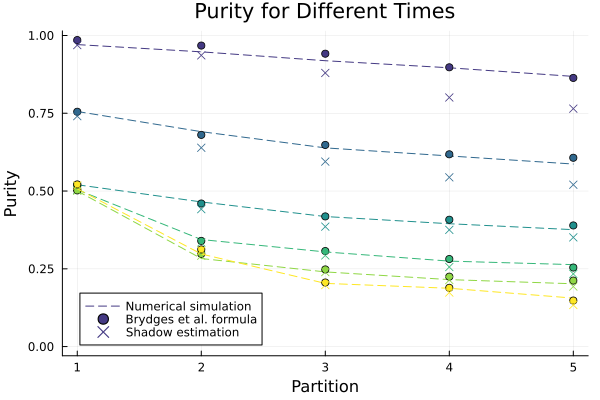

In [15]:
using Plots

# Create a new plot
plt = plot()

# Get the Viridis colormap gradient
cm = cgrad(:viridis)

# Loop over time points (assuming ntimes and NA_max are defined)
for s in 1:ntimes
    # Only add labels for the first iteration to avoid duplicate legend entries.
    label_num = s == 1 ? "Numerical simulation" : ""
    label_direct = s == 1 ? "Brydges et al. formula" : ""
    label_shadow = s == 1 ? "Shadow estimation" : ""
    
    # Plot the numerical simulation data with dashed lines
    plot!(plt, 1:NA_max, p[s, :, 1],
          linestyle = :dash,
          color = cm[s/ntimes],
          label = label_num)
    
    # Plot the direct calculation (Brydges et al. formula) with circle markers
    plot!(plt, 1:NA_max, p_direct[s, 1:NA_max],
          seriestype = :scatter,
          marker = :circle,
          color = cm[s/ntimes],
          label = label_direct)
    
    # Plot the shadow estimation with "x" markers
    plot!(plt, 1:NA_max, p_shadow[s, :, 1],
          seriestype = :scatter,
          marker = :x,
          color = cm[s/ntimes],
          label = label_shadow)
end

# Optionally, set a logarithmic scale for the y-axis
# yaxis!(plt, :log10)

xlabel!(plt, "Partition")
ylabel!(plt, "Purity")
title!(plt, "Purity for Different Times")

# Display the final plot
display(plt)

We plot the higher order Renyi entropies as a function of Renyi index n for a fixed subystem size and various times.

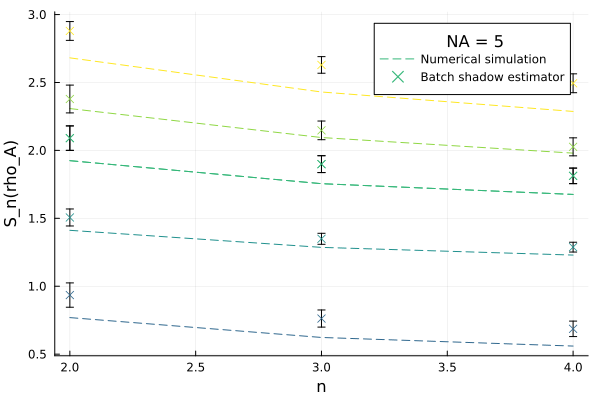

In [16]:
using Plots

# Assume that k_max, p, p_bshadow, and ntimes are defined elsewhere
NA = 5

# Initialize a new plot and obtain the Viridis colormap.
plt = plot()
cm = cgrad(:viridis)

# Plot for s = 1 with labels.
s = 4
plot!(plt, 2:k_max, S[s, NA, :],
      linestyle = :dash,
      color = cm[s/ntimes],
      label = "Numerical simulation")
plot!(plt, 2:k_max, S_bshadow[s, NA, :],yerr = S_bshadow_sem[s, NA, :],
      seriestype = :scatter,
      marker = :x,
      color = cm[s/ntimes],
      label = "Batch shadow estimator")

# Plot for s = 2:ntimes without additional labels.
for s in 2:ntimes
    plot!(plt, 2:k_max, S[s, NA, :],
          linestyle = :dash,
          color = cm[s/ntimes],
          label = "")
    plot!(plt, 2:k_max, S_bshadow[s, NA, :],yerr = S_bshadow_sem[s, NA, :],
          seriestype = :scatter,
          marker = :x,
          color = cm[s/ntimes],
          label = "")
end

xlabel!(plt, "n")
ylabel!(plt, "S_n(rho_A)")
plot!(plt, legend = :best, legendtitle = "NA = $NA")

display(plt)
